# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 


 Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path
import sklearn
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
from sklearn.metrics import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure
import seaborn as sns
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

C:\Users\Kadem\AppData\Local\Temp\ipykernel_76560\1374372186.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data loading



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [4]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(709, 'power'), (306, 'designed'), (754, 'reference'), (435, 'graphics'), (635, 'news'), (842, 'source'), (286, 'cx'), (278, 'crime'), (690, 'place'), (395, 'following')]


In [5]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [6]:
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nombre de mots=",len(words))
# Lets find the most frequence words Your code here

Nombre de mots= 3252437


In [7]:
import collections

words = corpus.split()
words_counter = collections.Counter(words)
top_100_words = words_counter.most_common(100)
top_100_words

[('the', 127670),
 ('to', 69836),
 ('of', 66705),
 ('a', 56148),
 ('and', 52580),
 ('is', 39554),
 ('in', 37787),
 ('I', 37616),
 ('that', 34582),
 ('>', 27843),
 ('for', 25707),
 ('you', 19874),
 ('it', 19698),
 ('be', 18364),
 ('on', 18201),
 ('have', 17292),
 ('are', 17260),
 ('with', 16179),
 ('not', 15434),
 ('The', 14079),
 ('this', 13611),
 ('as', 13373),
 ('or', 12497),
 ('was', 12426),
 ('Subject:', 11642),
 ('From:', 11536),
 ('Lines:', 11328),
 ('Organization:', 10881),
 ('by', 10279),
 ('but', 10265),
 ('|', 10072),
 ('from', 9859),
 ('at', 9807),
 ('-', 9662),
 ('they', 9591),
 ('an', 9393),
 ('will', 8584),
 ('can', 8493),
 ('would', 8381),
 ('In', 7904),
 ('if', 7792),
 ('about', 7768),
 ('Re:', 7747),
 ('my', 7679),
 ('--', 7639),
 ('writes:', 7505),
 ('your', 6972),
 ('has', 6969),
 ('do', 6930),
 ('all', 6745),
 ('one', 6576),
 ('|>', 6521),
 ('article', 6402),
 ('what', 6183),
 ('we', 6047),
 ('there', 5798),
 ('any', 5759),
 ('who', 5734),
 ('some', 5682),
 ('he', 5

### Plot the N frequent words and verify that its follows a Zipf law

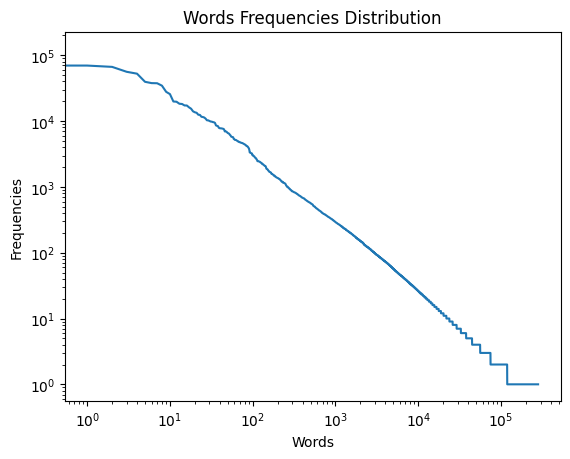

In [8]:
dic = dict(words_counter)
keys = list(dic.keys())
values = np.array(list(dic.values()))
sort = -np.sort(-values)
argsort = np.argsort(-values)

# plot
plt.title('Words Frequencies Distribution')
plt.loglog(np.arange(len(keys)), sort)
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.show()

<font color='bleu'>On peut voir que la distribution des fréquences des mots suit la loi de Zipf<font>

### Experiment word clouds

(-0.5, 399.5, 199.5, -0.5)

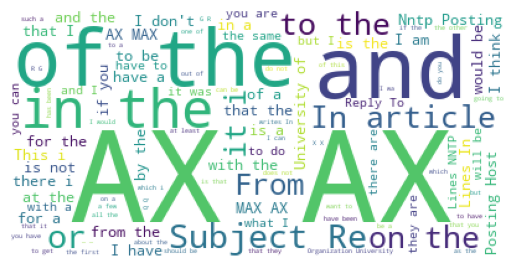

In [9]:
wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

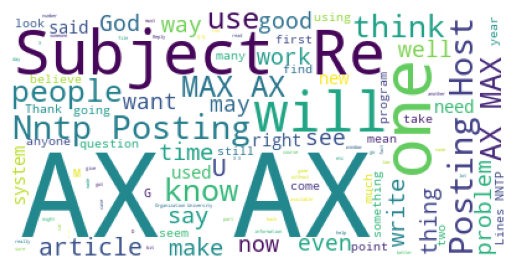

In [10]:
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

couintvec = CountVectorizer()
X = couintvec.fit_transform(data)

In [12]:
sum_0 = X.sum(0)
words_freq = [(word, sum_0[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq = dict(words_freq)

(-0.5, 399.5, 199.5, -0.5)

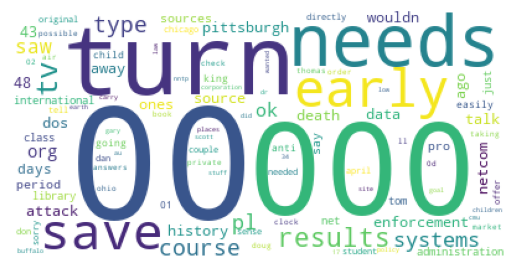

In [13]:
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate_from_frequencies(words_freq) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Drawing word clouds from classes


In [14]:
y = newsgroups_train.target

def plot_wordclouds(unique_classes, data):
    fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(15, 10))
    ax = ax.flatten()

    for i, class_name in enumerate(unique_classes):
        class_idx = np.nonzero(y == class_name)[0]  # Corrected indexing
        vectorizer_cv = CountVectorizer(stop_words="english")
        tmp = vectorizer_cv.fit_transform(data[class_idx])
        freq_dict = pd.Series(np.array(tmp.sum(axis=0))[0], index=sorted(vectorizer_cv.vocabulary_))
        wordcloud = WordCloud(
            background_color='white',
            stopwords=STOPWORDS,
            max_words=100).generate_from_frequencies(frequencies=freq_dict)
        ax[i].imshow(wordcloud)
        ax[i].axis("off")
        ax[i].set_title(f"Class: {class_name+1}")

    plt.tight_layout()
    plt.show()

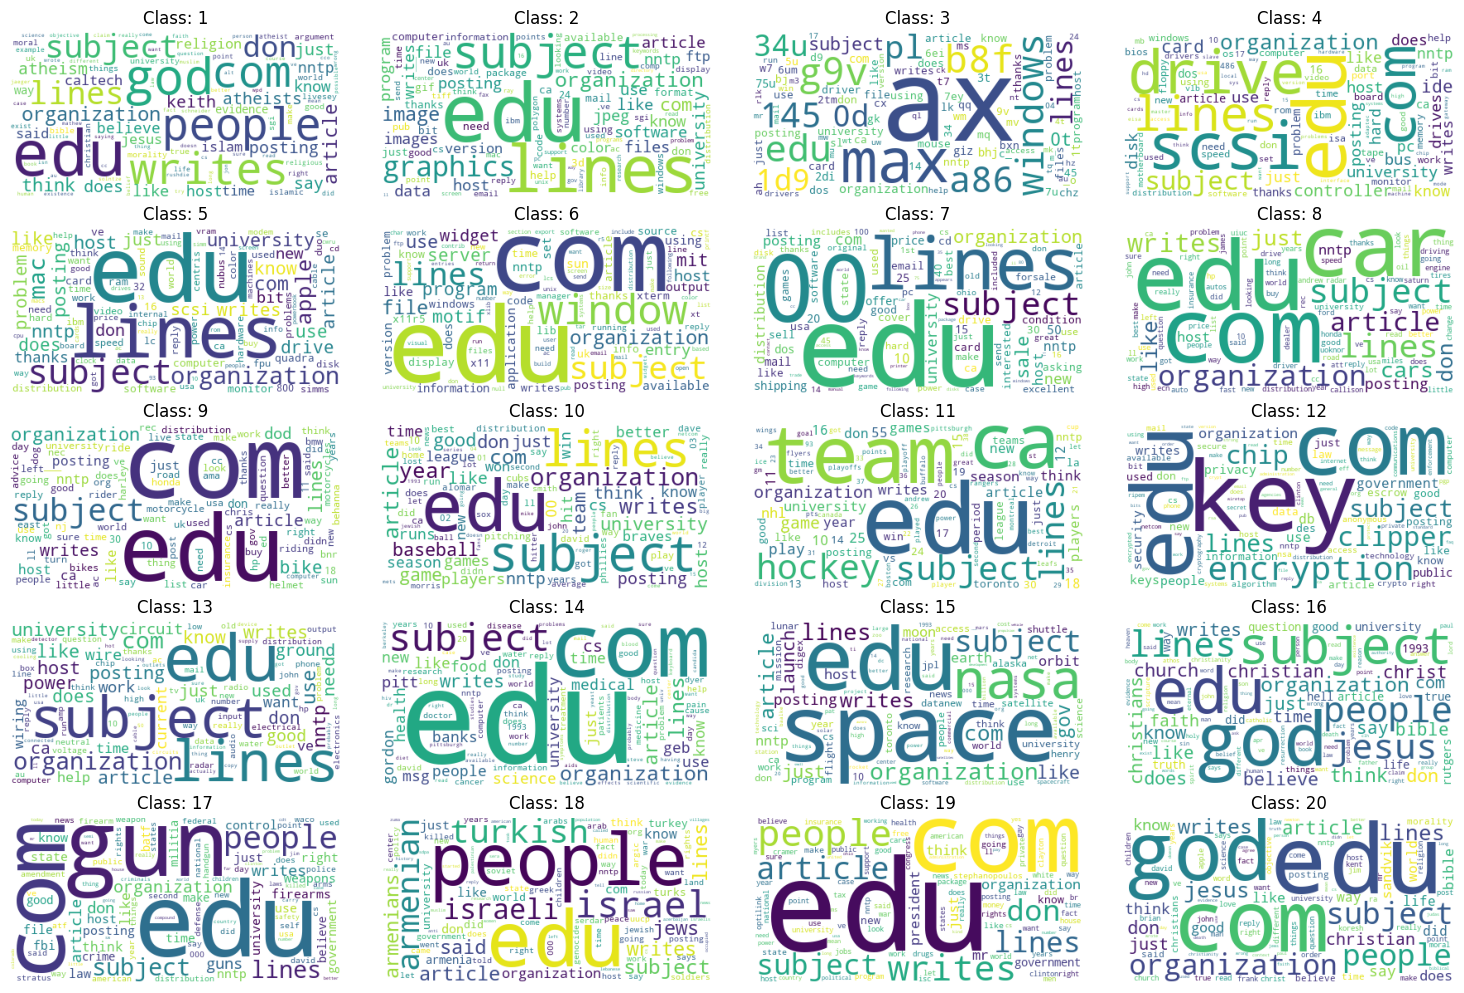

In [15]:
y = newsgroups_train.target
unique_classes = np.unique(y)
plot_wordclouds(unique_classes, data)

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [16]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
kmeans.cluster_centers_

Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2288.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\Kadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2288.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2288.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2288.0_x64__qbz5n2kfra8p0\Lib\encodings\cp125

array([[0.10756056, 0.02727664, 0.01102787, ..., 0.00212592, 0.00593682,
        0.00501284],
       [0.00523323, 0.01669429, 0.00168778, ..., 0.00636396, 0.00279291,
        0.0026637 ],
       [0.00212163, 0.00200874, 0.00086759, ..., 0.00221913, 0.00042353,
        0.        ],
       ...,
       [0.00234538, 0.00195804, 0.00063837, ..., 0.0051056 , 0.00321528,
        0.00236145],
       [0.00252404, 0.00392048, 0.002013  , ..., 0.00594924, 0.00468899,
        0.00315283],
       [0.00374857, 0.00500582, 0.00028979, ..., 0.00708021, 0.01223925,
        0.01180756]])

### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= |y^*_j|$, where $y^*_j$ is the most frequent (GT) label in cluster $C_j$ $\Rightarrow$ $p = \frac{1}{N}\sum\limits_j  p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

## Qualitative Analysis

In [17]:
labels = newsgroups_train.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"On a {len(newsgroups_train.data)} documents")
print(f"On a {true_k} categories")

On a 11314 documents
On a 20 categories


In [18]:
# Les mots les plus importants de chaque cluster
most_important_word_index = np.abs(kmeans.cluster_centers_).argmax(1)

print("the most important words for each cluster :")
for cl, i in enumerate(most_important_word_index):
    print(f"cluster {cl+1} : {vectorizer.get_feature_names_out()[i]}")

the most important words for each cluster :
cluster 1 : sale
cluster 2 : car
cluster 3 : drive
cluster 4 : uk
cluster 5 : key
cluster 6 : god
cluster 7 : pitt
cluster 8 : netcom
cluster 9 : people
cluster 10 : uiuc
cluster 11 : nasa
cluster 12 : windows
cluster 13 : andrew
cluster 14 : ca
cluster 15 : edu
cluster 16 : card
cluster 17 : ohio
cluster 18 : edu
cluster 19 : com
cluster 20 : team


Text(0.5, 1.0, 'The distribution of different documents across the 20 clusters')

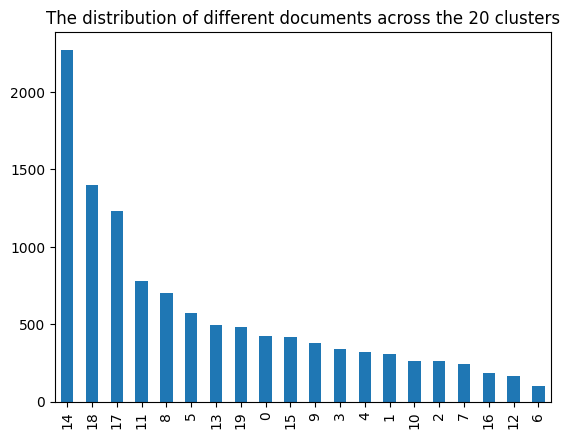

In [19]:
y_pred = kmeans.predict(vectors)
predictions = pd.Series(y_pred)

predictions.value_counts().plot.bar()
plt.gca().set_title('The distribution of different documents across the 20 clusters')

Word cloud par clusters - K-Means


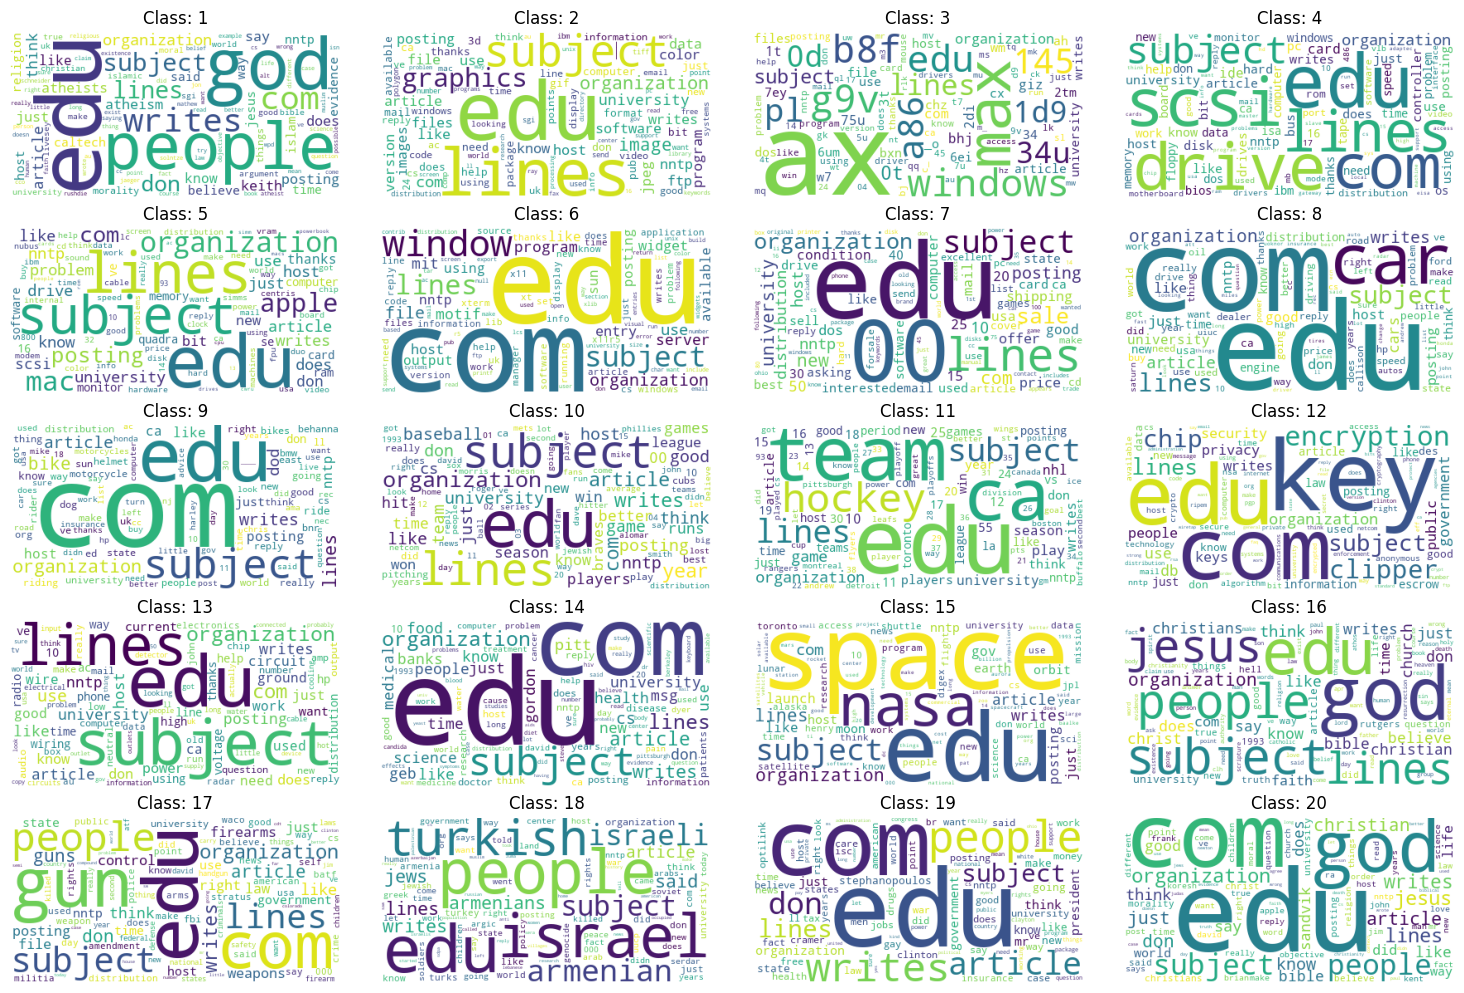

In [20]:
print("Word cloud par clusters - K-Means")
plot_wordclouds(unique_classes, data)

    

<font color='bleu'>On remarque que les word clouds ne change pas vraiment<font>

## Quantitative Analysis

In [21]:
# Compute purity
purity = 0
for y in np.unique(y_pred):
    idx = np.where(y_pred == y)[0]
    res = Y[idx]
    uy, cy = np.unique(res, return_counts=True)
    purity += np.max(cy)
purity /= len(y_pred)
print("Cluster purity:", purity)

Cluster purity: 0.3017500441930352


In [22]:
# Compute [Rand Score] and [Adjusted Rand Score]

rand_score = rand_score(y_pred, Y)
adj_rand_score = adjusted_rand_score(y_pred, Y)

print("Rand score :", rand_score)
print("Adjusted Rand Score :", adj_rand_score)

Rand score : 0.8823682422919308
Adjusted Rand Score : 0.10730567395686359


In [23]:
# Compute Silhouette Score

# How well each sample in a cluster is separated from samples in other clusters. 
# It takes values between -1 and 1, where higher values indicate better clustering.

silhouette_avg = silhouette_score(X, y_pred)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: -0.254423990171382


In [24]:
# Compute omogeneity, Completeness, and V-measure

# These metrics evaluate the extent to which each cluster contains only samples from a single class (homogeneity).adjusted_rand_score
# The extent to which samples from the same class are assigned to the same cluster (completeness), and their harmonic mean (V-measure). 

homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(Y, y_pred)
print("Homogeneity:", homogeneity)
print("Completeness:", completeness)
print("V-measure:", v_measure)

Homogeneity: 0.26972580939985824
Completeness: 0.30018475366836905
V-measure: 0.2841413404124072


# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [25]:
# t-SNE from the U matrix computed by LSA
# Dimensionality reduction with LSA
lsa = TruncatedSVD(n_components=50)
U = lsa.fit_transform(vectors)

# t-SNE embedding
tsne = TSNE(n_components=2, init='pca', n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.000s...
[t-SNE] Computed neighbors for 11314 samples in 0.354s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.115760
[t-SNE] Computed cond

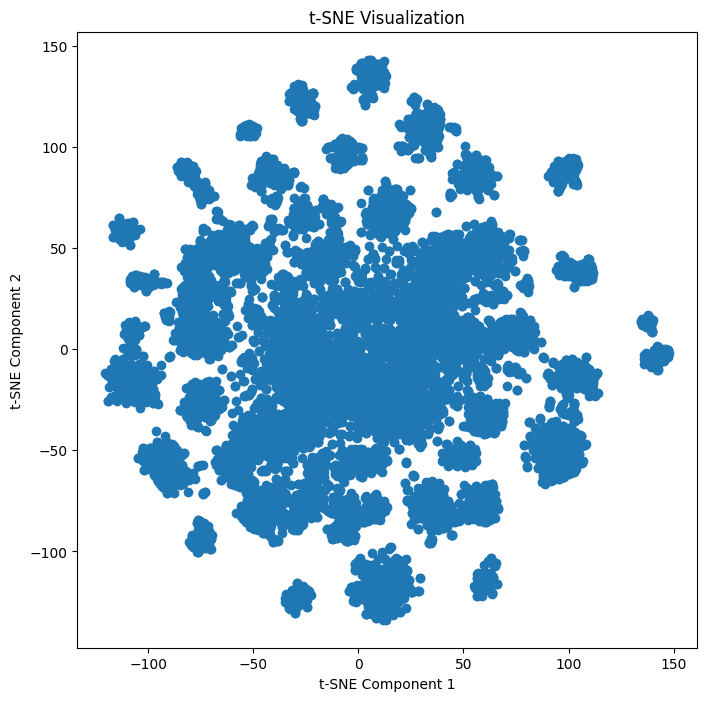

In [26]:
# Plotting the t-SNE embedding
plt.figure(figsize=(8, 8))
plt.scatter(tsne_mat[:, 0], tsne_mat[:, 1])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()

C:\Users\Kadem\AppData\Local\Temp\ipykernel_76560\3898341844.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv', 20)
C:\Users\Kadem\AppData\Local\Temp\ipykernel_76560\3898341844.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet', 20)


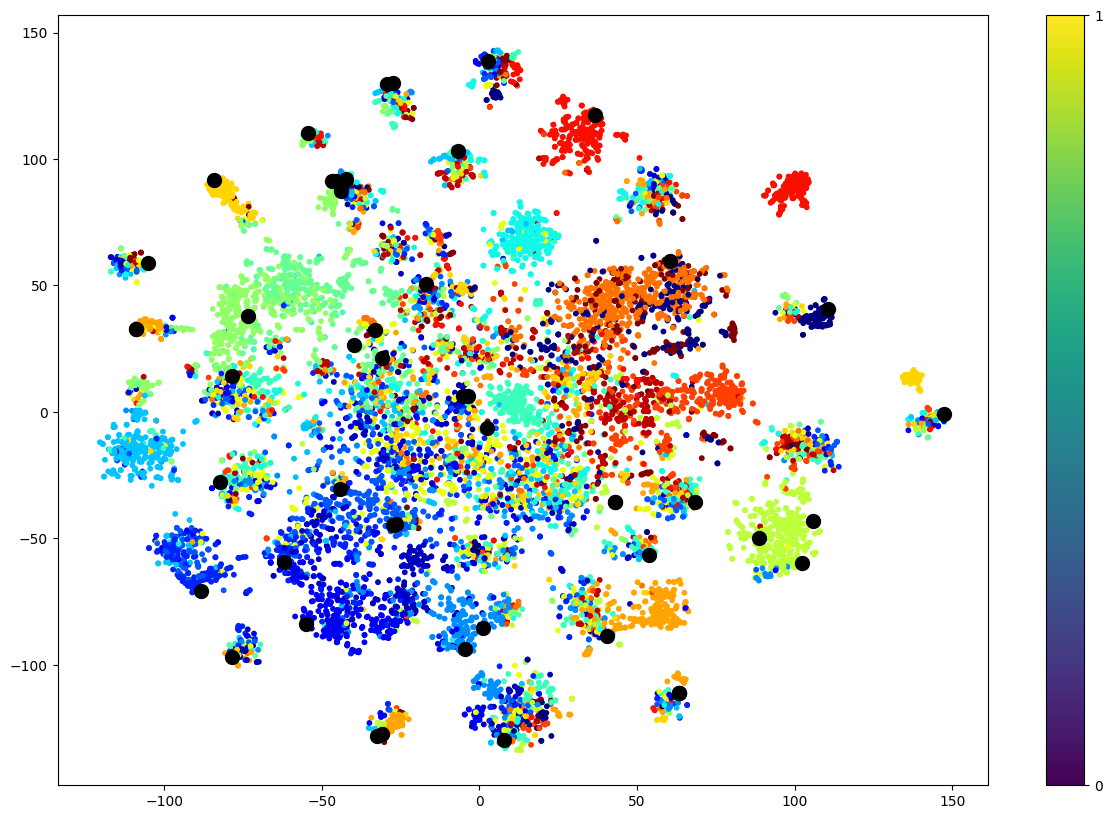

In [27]:
NN2cluster = np.argmax(np.abs(U), axis=0)
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [28]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))



C:\Users\Kadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(11314, 1000)
48.02527841612162


# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**

In [31]:
kmeans_lsa = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(U)
kmeans_lsa.cluster_centers_.shape

(20, 50)

In [32]:
# Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
Y_pred = kmeans_lsa.predict(U)
print(Y_pred[:10])
print(np.unique(Y_pred))

[13 12 13  9  9  1 12  7 15 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [34]:
from sklearn.metrics import rand_score

# Calcul de la pureté du cluster
purity = 0
for y in np.unique(Y_pred):
    idx = np.where(Y_pred == y)[0]
    res = Y[idx]
    uy, cy = np.unique(res, return_counts=True)
    purity += np.max(cy)
purity /= len(Y_pred)

# Affichage de la pureté du cluster
print("Pureté du cluster :", purity)

# Calcul et affichage du rand_score
rs = rand_score(Y_pred, Y)
print("Rand_score :", rs)

# Calcul et affichage de l'adjusted_rand_score
ars = adjusted_rand_score(Y_pred, Y)
print("Adjusted_rand_score :", ars)

Pureté du cluster : 0.31704083436450414
Rand_score : 0.8796606424914943
Adjusted_rand_score : 0.10688884294256892


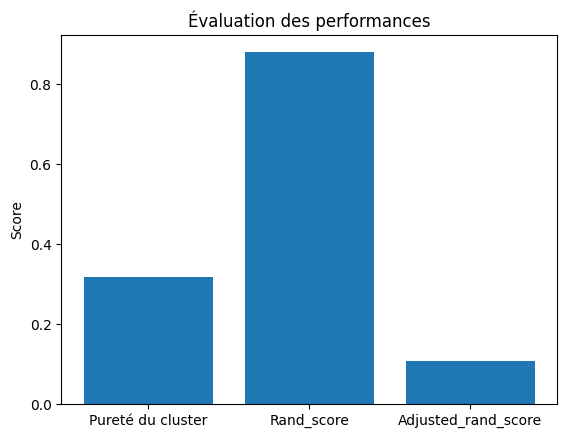

In [37]:
import matplotlib.pyplot as plt
labels = ['Pureté du cluster', 'Rand_score', 'Adjusted_rand_score']
values = [purity, rs, ars]

plt.bar(labels, values)
plt.ylabel('Score')
plt.title('Évaluation des performances')

plt.show()

In [49]:
kmeans_lda = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
kmeans_lda.cluster_centers_.shape

(20, 1000)

In [50]:
# Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
Y_pred = kmeans_lda.predict(vectors)
print(Y_pred[:10])
print(np.unique(Y_pred))

[5 5 5 5 5 5 5 5 5 5]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [51]:
# Calcul de la pureté du cluster
purity = 0
for y in np.unique(Y_pred):
    idx = np.where(Y_pred == y)[0]
    res = Y[idx]
    uy, cy = np.unique(res, return_counts=True)
    purity += np.max(cy)
purity /= len(Y_pred)

# Affichage de la pureté du cluster
print("Pureté du cluster :", purity)

# Calcul et affichage du rand_score
rs = rand_score(Y_pred, Y)
print("Rand_score :", rs)

Pureté du cluster : 0.05709740144953156
Rand_score : 0.06242217584238769


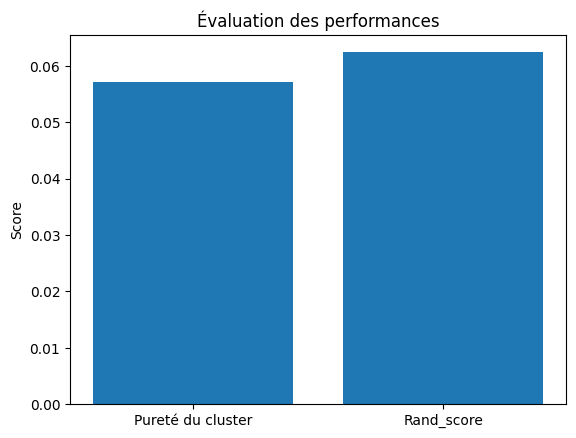

In [48]:
import matplotlib.pyplot as plt
labels = ['Pureté du cluster', 'Rand_score']
values = [purity, rs]

plt.bar(labels, values)
plt.ylabel('Score')
plt.title('Évaluation des performances')

plt.show()